In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="x4nNkSfXdcfGcPufObnD")
project = rf.workspace("g3-32st4").project("categorize-car-brands")
version = project.version(1)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Categorize-car-brands-1 in folder:: 100%|██████████| 2155/2155 [00:01<00:00, 1417.75it/s]


Найдена папка датасета: /content/Categorize-car-brands-1

Всего классов: 18
Train:  1830 изображений
Valid:  177 изображений
Test:   89 изображений
Общее:  2096



,class,train,valid,test,total
17,Volkswagen,120,5,5,130
4,Ford,120,7,3,130
12,MercedesBenz,118,4,5,127
3,Chevrolet,116,6,4,126
14,Porsche,109,9,4,122
1,Audi,108,8,6,122
15,Tesla,108,6,6,120
9,Lamborghini,104,9,5,118
11,Mazda,102,15,1,118
2,BMW,100,11,5,116




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



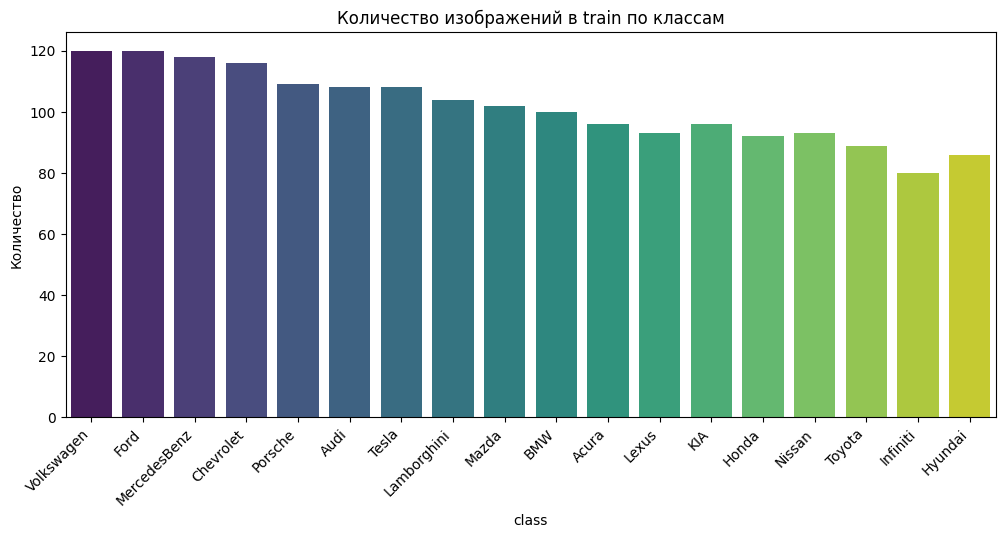

In [5]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Автоматически найдём папку датасета (Roboflow всегда кладёт в текущую директорию)
possible_names = ["/content/Categorize-car-brands-1", "/content/Categorize Car Brands-1", "/content/categorize car brands-1"]
dataset_path = None
for name in possible_names:
    if os.path.exists(name):
        dataset_path = name
        break

if dataset_path is None:
    raise FileNotFoundError("Папка датасета не найдена! Проверь название или скачай заново.")

print(f"Найдена папка датасета: {dataset_path}\n")

def count_images_in_split(split_path):
    counts = {}
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")
test_path  = os.path.join(dataset_path, "test")

train_counts = count_images_in_split(train_path)
valid_counts = count_images_in_split(valid_path)
test_counts  = count_images_in_split(test_path)

classes = sorted(train_counts.keys())
num_classes = len(classes)

# Общие цифры
total_train = sum(train_counts.values())
total_valid = sum(valid_counts.values())
total_test  = sum(test_counts.values())

print(f"Всего классов: {num_classes}")
print(f"Train:  {total_train} изображений")
print(f"Valid:  {total_valid} изображений")
print(f"Test:   {total_test} изображений")
print(f"Общее:  {total_train + total_valid + total_test}\n")

# Красивая табличка
data = []
for cls in classes:
    data.append({
        "class": cls,
        "train": train_counts.get(cls, 0),
        "valid": valid_counts.get(cls, 0),
        "test":  test_counts.get(cls, 0),
        "total": train_counts.get(cls, 0) + valid_counts.get(cls, 0) + test_counts.get(cls, 0)
    })

df = pd.DataFrame(data).sort_values("total", ascending=False)
display(df)

# График распределения
plt.figure(figsize=(12,5))
sns.barplot(data=df, x="class", y="train", palette="viridis")
plt.title("Количество изображений в train по классам")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Количество")
plt.show()

In [6]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -----------------------------
# Настройки
# -----------------------------
IMG_SIZE = 224
BATCH_SIZE = 64  # увеличено для ускорения обучения
EPOCHS = 10      # можно увеличить
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_path = "/content/Categorize-car-brands-1"

In [7]:
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2,0.2,0.2,0.02),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(os.path.join(dataset_path,"train"), transform=train_tf)
val_ds   = datasets.ImageFolder(os.path.join(dataset_path,"valid"), transform=val_tf)
test_ds  = datasets.ImageFolder(os.path.join(dataset_path,"test"),  transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = train_ds.classes
num_classes = len(classes)
print("Classes:", classes)

Classes: ['Acura', 'Audi', 'BMW', 'Chevrolet', 'Ford', 'Honda', 'Hyundai', 'Infiniti', 'KIA', 'Lamborghini', 'Lexus', 'Mazda', 'MercedesBenz', 'Nissan', 'Porsche', 'Tesla', 'Toyota', 'Volkswagen']


In [8]:
def get_model(model_name="efficientnet", num_classes=num_classes, pretrained=True):
    if model_name.lower() == "efficientnet":
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
    elif model_name.lower() == "resnet":
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    elif model_name.lower() == "densenet":
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    elif model_name.lower() == "vgg":
        model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1 if pretrained else None)
        in_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(in_features, num_classes)
    else:
        raise ValueError("Unknown model name")
    return model.to(device)

In [10]:
param_grid = {
    "model_name": ["efficientnet", "resnet", "densenet", "vgg"],
    "lr": [1e-3, 1e-4]
}

best_val_acc = 0
best_params = None
best_model_state = None

for model_name in param_grid["model_name"]:
    for lr in param_grid["lr"]:
        print(f"\nTraining: {model_name}, lr={lr}")
        model = get_model(model_name)

        # Weighted CrossEntropyLoss
        class_counts = [len(os.listdir(os.path.join(dataset_path,"train", c))) for c in classes]
        class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
        class_weights = class_weights / class_weights.sum() * num_classes
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

        # Optimizer (только Adam)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Scheduler без verbose
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

        # Training loop
        for epoch in range(EPOCHS):
            model.train()
            running_loss = 0
            for imgs, labels in train_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0
            correct, total = 0, 0
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for imgs, labels in val_loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    preds = outputs.argmax(dim=1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            val_acc = correct / total * 100
            val_loss /= len(val_loader)
            scheduler.step(val_loss)  # шаг scheduler по loss
            print(f"Epoch [{epoch+1}/{EPOCHS}] Val Acc: {val_acc:.2f}% Loss: {val_loss:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = {"model_name": model_name, "lr": lr}
            best_model_state = model.state_dict()

print("\nBest Hyperparameters:", best_params)
print("Best Validation Accuracy:", best_val_acc)



Training: efficientnet, lr=0.001
Epoch [1/10] Val Acc: 80.23% Loss: 0.7194
Epoch [2/10] Val Acc: 83.05% Loss: 0.5225
Epoch [3/10] Val Acc: 86.44% Loss: 0.5370
Epoch [4/10] Val Acc: 85.31% Loss: 0.4838
Epoch [5/10] Val Acc: 84.75% Loss: 0.5661
Epoch [6/10] Val Acc: 84.75% Loss: 0.7552
Epoch [7/10] Val Acc: 85.88% Loss: 0.5269
Epoch [8/10] Val Acc: 88.14% Loss: 0.4428
Epoch [9/10] Val Acc: 88.70% Loss: 0.3941
Epoch [10/10] Val Acc: 90.96% Loss: 0.3811

Training: efficientnet, lr=0.0001
Epoch [1/10] Val Acc: 23.16% Loss: 2.7299
Epoch [2/10] Val Acc: 38.42% Loss: 2.4273
Epoch [3/10] Val Acc: 50.85% Loss: 1.9971
Epoch [4/10] Val Acc: 68.93% Loss: 1.5233
Epoch [5/10] Val Acc: 79.66% Loss: 1.1205
Epoch [6/10] Val Acc: 84.75% Loss: 0.8695
Epoch [7/10] Val Acc: 87.57% Loss: 0.6872
Epoch [8/10] Val Acc: 87.57% Loss: 0.6093
Epoch [9/10] Val Acc: 89.83% Loss: 0.5451
Epoch [10/10] Val Acc: 90.40% Loss: 0.4875

Training: resnet, lr=0.001
Epoch [1/10] Val Acc: 67.23% Loss: 1.2585
Epoch [2/10] Val Ac

100%|██████████| 30.8M/30.8M [00:00<00:00, 165MB/s]


Epoch [1/10] Val Acc: 61.02% Loss: 1.3918
Epoch [2/10] Val Acc: 74.58% Loss: 0.9062
Epoch [3/10] Val Acc: 81.92% Loss: 0.7883
Epoch [4/10] Val Acc: 82.49% Loss: 0.7233
Epoch [5/10] Val Acc: 75.14% Loss: 1.0442
Epoch [6/10] Val Acc: 78.53% Loss: 0.7758
Epoch [7/10] Val Acc: 84.18% Loss: 0.6526
Epoch [8/10] Val Acc: 79.66% Loss: 0.7185
Epoch [9/10] Val Acc: 85.88% Loss: 0.5159
Epoch [10/10] Val Acc: 89.83% Loss: 0.4397

Training: densenet, lr=0.0001
Epoch [1/10] Val Acc: 53.11% Loss: 2.0094
Epoch [2/10] Val Acc: 79.10% Loss: 1.1065
Epoch [3/10] Val Acc: 90.40% Loss: 0.7094
Epoch [4/10] Val Acc: 91.53% Loss: 0.5344
Epoch [5/10] Val Acc: 94.92% Loss: 0.4309
Epoch [6/10] Val Acc: 94.35% Loss: 0.3492
Epoch [7/10] Val Acc: 94.35% Loss: 0.3284
Epoch [8/10] Val Acc: 95.48% Loss: 0.2803
Epoch [9/10] Val Acc: 95.48% Loss: 0.2646
Epoch [10/10] Val Acc: 95.48% Loss: 0.2607

Training: vgg, lr=0.001
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkp

100%|██████████| 528M/528M [00:04<00:00, 111MB/s]


Epoch [1/10] Val Acc: 4.52% Loss: 2.8891
Epoch [2/10] Val Acc: 2.26% Loss: 2.9004
Epoch [3/10] Val Acc: 3.39% Loss: 2.9313
Epoch [4/10] Val Acc: 7.91% Loss: 3.0790
Epoch [5/10] Val Acc: 9.04% Loss: 2.8668
Epoch [6/10] Val Acc: 9.04% Loss: 2.8121
Epoch [7/10] Val Acc: 10.17% Loss: 2.7997
Epoch [8/10] Val Acc: 10.17% Loss: 2.8127
Epoch [9/10] Val Acc: 10.17% Loss: 2.7920
Epoch [10/10] Val Acc: 10.73% Loss: 2.7918

Training: vgg, lr=0.0001
Epoch [1/10] Val Acc: 39.55% Loss: 1.9093
Epoch [2/10] Val Acc: 75.14% Loss: 0.8036
Epoch [3/10] Val Acc: 80.23% Loss: 0.7896
Epoch [4/10] Val Acc: 85.31% Loss: 0.6981
Epoch [5/10] Val Acc: 82.49% Loss: 0.7559
Epoch [6/10] Val Acc: 87.57% Loss: 0.7189
Epoch [7/10] Val Acc: 85.88% Loss: 0.7107
Epoch [8/10] Val Acc: 85.31% Loss: 0.7547
Epoch [9/10] Val Acc: 87.57% Loss: 0.8856
Epoch [10/10] Val Acc: 87.01% Loss: 0.8522

Best Hyperparameters: {'model_name': 'densenet', 'lr': 0.0001}
Best Validation Accuracy: 95.48022598870057


Top-1 Accuracy: 87.01%
Top-3 Accuracy: 93.22%

Classification Report:

              precision    recall  f1-score   support

       Acura       0.75      0.92      0.83        13
        Audi       0.88      0.88      0.88         8
         BMW       0.89      0.73      0.80        11
   Chevrolet       1.00      0.67      0.80         6
        Ford       0.78      1.00      0.88         7
       Honda       0.80      0.73      0.76        11
     Hyundai       0.91      0.91      0.91        11
    Infiniti       0.87      0.93      0.90        14
         KIA       1.00      1.00      1.00        12
 Lamborghini       1.00      0.89      0.94         9
       Lexus       1.00      0.64      0.78        11
       Mazda       1.00      0.87      0.93        15
MercedesBenz       0.67      1.00      0.80         4
      Nissan       0.91      0.91      0.91        11
     Porsche       0.69      1.00      0.82         9
       Tesla       0.86      1.00      0.92         6
      Toyo

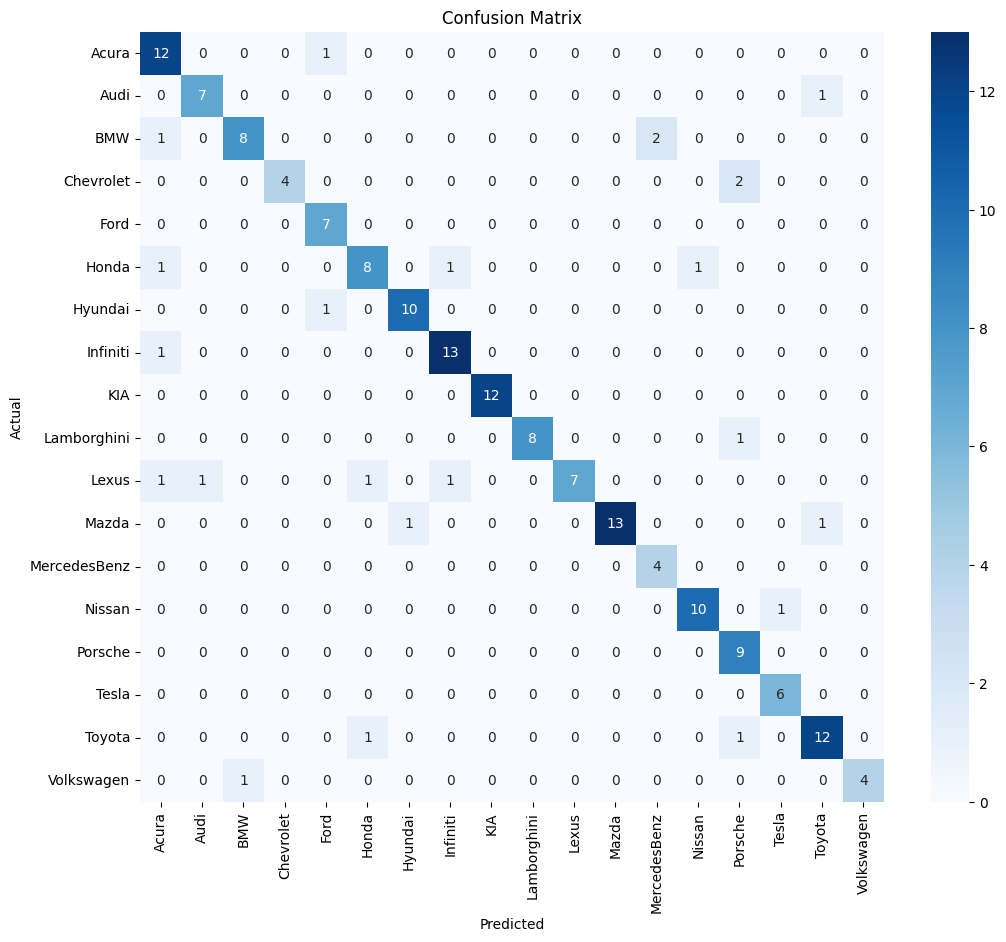

In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, top_k_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

# ------------------------------
# Подготовка для оценки
# ------------------------------
all_logits = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)  # логиты
        all_logits.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_logits = np.concatenate(all_logits, axis=0)  # [N, num_classes]
all_labels = np.concatenate(all_labels, axis=0)  # [N]

# ------------------------------
# Top-1 и Top-3 Accuracy
# ------------------------------
top1_acc = top_k_accuracy_score(all_labels, all_logits, k=1)  # обычная точность
top3_acc = top_k_accuracy_score(all_labels, all_logits, k=3)

print(f"Top-1 Accuracy: {top1_acc*100:.2f}%")
print(f"Top-3 Accuracy: {top3_acc*100:.2f}%\n")

# ------------------------------
# Classification Report
# ------------------------------
preds = np.argmax(all_logits, axis=1)
print("Classification Report:\n")
print(classification_report(all_labels, preds, target_names=classes))

# ------------------------------
# Confusion Matrix
# ------------------------------
cm = confusion_matrix(all_labels, preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [14]:
save_path = "/content/best_car_brand_model.pth"

torch.save({
    "model_state_dict": best_model_state,  # веса модели
    "num_classes": num_classes,            # число классов
    "classes": classes,                    # имена классов
    "model_name": best_params["model_name"],  # какая архитектура использовалась
    "img_size": IMG_SIZE                   # размер изображений
}, save_path)

print(f"Модель сохранена в {save_path}")

Модель сохранена в /content/best_car_brand_model.pth
